# **H2O GBM**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix

import h2o

In [2]:
h2o.init(nthreads=10)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,9 days 2 hours 26 mins
H2O cluster timezone:,Asia/Seoul
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,"1 year, 9 months and 26 days !!!"
H2O cluster name:,h2o
H2O cluster total nodes:,1
H2O cluster free memory:,78.9 Gb
H2O cluster total cores:,64
H2O cluster allowed cores:,64
H2O cluster status:,"locked, healthy"


In [3]:
train=h2o.import_file('../train.csv')
test=h2o.import_file('../test.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
x =train.columns
y = 'FDS_CATH'
x.remove(y)
x.remove('FRST_RCV_DT')

In [5]:
train[y] = train[y].asfactor()

In [6]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

# GBM hyperparameters
gbm_params = {'learn_rate': [i * 0.01 for i in range(1, 31)],  #updated
                'max_depth': list(range(2, 11)),
                'sample_rate': [0.9, 0.95, 1.0],  #updated
                'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_runtime_secs': 60}  #updated

In [7]:
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid',
                          hyper_params=gbm_params,
                          search_criteria=search_criteria)
gbm_grid.train(x=x, y=y, 
                training_frame=train,  
                ntrees=100,
                seed=1)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [8]:
def get_result(model, h2o_data, target, n_group=10):
    pred_result=model.predict(h2o_data)
    performance=model.model_performance(h2o_data)
    pred_result.as_data_frame()

    #h2oframe을 dataframe으로 변환
    pred_result=h2o.as_list(pred_result, use_pandas=True)
    h2o_data=h2o.as_list(h2o_data, use_pandas=True)

    score=pd.concat([h2o_data[target].reset_index().drop('index', axis=1), pred_result['p1']], axis=1)
    score.sort_values('p1', ascending=False, inplace=True)
    score = score.reset_index().drop('index', axis = 1).copy()
    
    n_group=10
    group=['G01','G02','G03','G04','G05','G06','G07','G08','G09','G10']
    bins=round(len(score)/n_group)
    bins_1=len(score)-bins*(n_group-1)

    group_list=[]
    for i in range(n_group):
        if i <n_group-1:
            group_list.append(np.repeat(group[i], bins).tolist())
        else:
            group_list.append(np.repeat(group[i], bins_1).tolist())

    import itertools
    group_list=list(itertools.chain(*group_list))
    score['group']=pd.Series(group_list)

    function_list=['count', 'sum','mean']
    table=score.groupby(['group']).agg(function_list).reset_index()
    
    return score, table

In [9]:
def make_plot(score, table):
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(table['group'], table['FDS_CATH']['mean'], 'bo--')
    
    y_true=score['FDS_CATH']
    y_score=score['p1']
    test_preds=np.where(y_score >0.5, 1, 0)
    
    print(f'precision score:{precision_score(y_true, test_preds)}')
    print(f'recall score: {recall_score(y_true, test_preds)}')
    print(f'auc acore:{roc_auc_score(y_true, y_score)}')
    cm=confusion_matrix(y_true, test_preds)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confision matrix")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

In [10]:
test_score, test_table =get_result(gbm_grid.get_grid(sort_by='f1', decreasing=True).models[0], test, target='FDS_CATH')

gbm prediction progress: |████████████████████████████████████████████████| 100%


precision score:0.3770491803278688
recall score: 0.10043668122270742
auc acore:0.7670040642015588


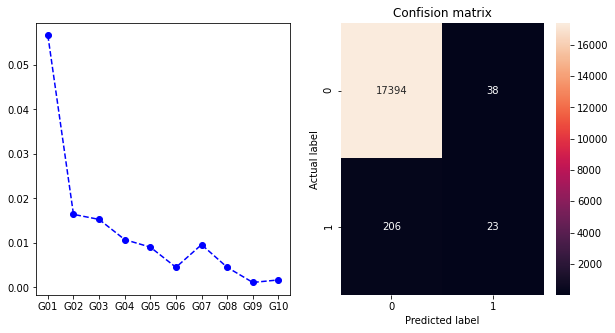

In [11]:
make_plot(test_score, test_table)

In [12]:
test_table

group FDS_CATH                   p1                      
           count  sum      mean count         sum      mean
0   G01     1766  100  0.056625  1766  195.948205  0.110956
1   G02     1766   29  0.016421  1766   77.147076  0.043685
2   G03     1766   27  0.015289  1766   58.479886  0.033114
3   G04     1766   19  0.010759  1766   48.477795  0.027451
4   G05     1766   16  0.009060  1766   40.841663  0.023127
5   G06     1766    8  0.004530  1766   34.706391  0.019653
6   G07     1766   17  0.009626  1766   26.446300  0.014975
7   G08     1766    8  0.004530  1766   18.231904  0.010324
8   G09     1766    2  0.001133  1766    9.242187  0.005233
9   G10     1767    3  0.001698  1767    4.249411  0.002405

In [13]:
train_score, train_table =get_result(gbm_grid.get_grid(sort_by='f1', decreasing=True).models[0], train, target='FDS_CATH')

gbm prediction progress: |████████████████████████████████████████████████| 100%


precision score:0.8906009244992296
recall score: 0.16104764558372806
auc acore:0.8248858164599873


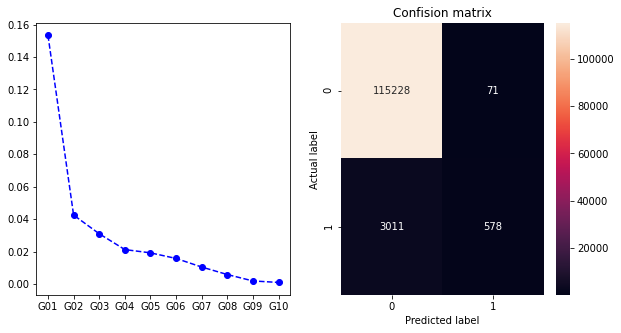

In [14]:
make_plot(train_score, train_table)

In [15]:
train_table

group FDS_CATH                     p1                       
           count   sum      mean  count          sum      mean
0   G01    11889  1823  0.153335  11889  1478.957236  0.124397
1   G02    11889   505  0.042476  11889   523.055968  0.043995
2   G03    11889   368  0.030953  11889   390.913318  0.032880
3   G04    11889   252  0.021196  11889   317.916198  0.026740
4   G05    11889   228  0.019177  11889   268.071268  0.022548
5   G06    11889   187  0.015729  11889   227.926190  0.019171
6   G07    11889   124  0.010430  11889   174.761115  0.014699
7   G08    11889    69  0.005804  11889   121.225131  0.010196
8   G09    11889    22  0.001850  11889    63.031420  0.005302
9   G10    11887    11  0.000925  11887    28.641975  0.002410